# Air Quality Index prediction based on image data
this model is built based on ResNet. This model have image as the data input. The output of the model is prediction of Air Quality Index (AQI) based on the image data. The dataset contains the data of air quality index in India. The data is collected from various cities in India. The data is collected from the year 2015 to 2020. The data contains the following columns:

In [54]:
import os
import pandas as pd
from datetime import datetime

print(os.listdir())
os.chdir('/home/fateenindramustika/predict-air-quality-with-ANN')
image_files = os.listdir('image-dataset')
# Extract the timestamp from each file name
image_timestamps = [datetime.strptime(os.path.splitext(file)[0][0:15], "%Y%m%d_%H%M%S") for file in image_files]
# print(image_timestamps)

data = {'File Name': image_files, 'Timestamp': image_timestamps}
df_image = pd.DataFrame(data)

image_timestamps = [os.path.splitext(file)[0] for file in image_files]

aqi_data = pd.read_csv('aqi-dataset/air_quality_data.csv')

# Assuming the timestamp is in a column named 'timestamp'
aqi_timestamps = aqi_data['Now Timestamp'].tolist()

# conver aqi_timestamps with this fromat 2024-05-27T10:01:37.112964
aqi_timestamps = [datetime.strptime(timestamp, "%Y-%m-%dT%H:%M:%S.%f") for timestamp in aqi_timestamps]

# create nyew dataframe to match aqi_timestamps with aqi_data
data = {'Timestamp': aqi_timestamps, 'AQI': aqi_data['AQI']}
df_aqi = pd.DataFrame(data)
print(df_aqi)

['vggnet.ipynb', 'aqi-dataset', 'models', 'resnet.ipynb', '.DS_Store', 'image-dataset', 'README.md', '.git', 'alexnet.ipynb']
                      Timestamp  AQI
0    2024-05-27 10:01:37.112964   56
1    2024-05-27 10:05:01.186524   56
2    2024-05-27 10:05:21.637891   56
3    2024-05-27 10:05:22.114247   56
4    2024-05-27 10:05:23.235149   56
...                         ...  ...
2057 2024-06-03 13:15:01.172904   82
2058 2024-06-03 13:20:01.068396   82
2059 2024-06-03 13:25:00.751539   82
2060 2024-06-03 13:30:01.331305   82
2061 2024-06-03 13:35:00.982839   82

[2062 rows x 2 columns]


In [55]:
def find_nearest(row, df, column='Timestamp'):
    absolute_difference_function = lambda x: abs(x - row['Timestamp'])
    nearest_timestamp = df[column].apply(absolute_difference_function).idxmin()
    return df.loc[nearest_timestamp]

nearest_aqi = df_image.apply(find_nearest, args=(df_aqi,), axis=1)

# Add the columns from nearest_aqi to df_image
df_image = pd.concat([df_image, nearest_aqi], axis=1)

In [56]:
print(df_image)
df_image.drop(columns=['Timestamp'], inplace=True)
df_image

               File Name           Timestamp                  Timestamp  AQI
0    20240526_133000.jpg 2024-05-26 13:30:00 2024-05-27 10:01:37.112964   56
1    20240529_170000.jpg 2024-05-29 17:00:00 2024-05-29 17:00:00.495326   93
2    20240602_133000.jpg 2024-06-02 13:30:00 2024-06-02 13:30:01.639884  107
3    20240530_180000.jpg 2024-05-30 18:00:00 2024-05-30 18:00:01.116402  160
4    20240601_160000.jpg 2024-06-01 16:00:00 2024-06-01 16:00:00.897258  154
..                   ...                 ...                        ...  ...
187  20240526_140000.jpg 2024-05-26 14:00:00 2024-05-27 10:01:37.112964   56
188  20240528_103000.jpg 2024-05-28 10:30:00 2024-05-28 10:30:00.510045   50
189  20240529_140000.jpg 2024-05-29 14:00:00 2024-05-29 14:00:00.573504  149
190  20240527_153000.jpg 2024-05-27 15:30:00 2024-05-27 15:30:00.829745   53
191  20240531_103000.jpg 2024-05-31 10:30:00 2024-05-31 10:30:01.072830  122

[192 rows x 4 columns]


,File Name,AQI
0,20240526_133000.jpg,56
1,20240529_170000.jpg,93
2,20240602_133000.jpg,107
3,20240530_180000.jpg,160
4,20240601_160000.jpg,154
...,...,...
187,20240526_140000.jpg,56
188,20240528_103000.jpg,50
189,20240529_140000.jpg,149
190,20240527_153000.jpg,53


In [57]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df_image, test_size=0.2, random_state=42)

In [58]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=0.2)
test_datagen = ImageDataGenerator(rescale=0.2)

In [59]:
train_generator = train_datagen.flow_from_dataframe(
    train_data,
    directory='image-dataset/',
    x_col='File Name',
    y_col='AQI',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw'
)
test_generator = test_datagen.flow_from_dataframe(
    test_data,
    directory='image-dataset/',
    x_col='File Name',
    y_col='AQI',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    shuffle=False
)


Found 153 validated image filenames.
Found 39 validated image filenames.


In [60]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load the ResNet50 model pre-trained on ImageNet
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of ResNet
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1)(x)  # Single output for AQI

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error',tf.keras.metrics.RootMeanSquaredError()])

# Summary of the model
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [61]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_data) // 32,
    validation_data=test_generator,
    validation_steps=len(test_data) // 32,
    epochs=1000  # Adjust the number of epochs based on your needs
)

Epoch 1/1000


2024-06-06 23:57:38.176823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - ETA: 0s - loss: 13518.2129 - mean_absolute_error: 90.8453 - root_mean_squared_error: 116.2679

2024-06-06 23:57:51.615507: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 18s 3s/step - loss: 13518.2129 - mean_absolute_error: 90.8453 - root_mean_squared_error: 116.2679 - val_loss: 3157.6423 - val_mean_absolute_error: 48.2571 - val_root_mean_squared_error: 56.1929
Epoch 2/1000
4/4 [==============================] - 9s 2s/step - loss: 5765.4180 - mean_absolute_error: 49.1287 - root_mean_squared_error: 75.9304 - val_loss: 2190.7690 - val_mean_absolute_error: 36.0734 - val_root_mean_squared_error: 46.8057
Epoch 3/1000
4/4 [==============================] - 9s 3s/step - loss: 7766.0405 - mean_absolute_error: 63.8235 - root_mean_squared_error: 88.1251 - val_loss: 3230.2256 - val_mean_absolute_error: 44.6379 - val_root_mean_squared_error: 56.8351
Epoch 4/1000
4/4 [==============================] - 10s 3s/step - loss: 5964.5356 - mean_absolute_error: 53.6248 - root_mean_squared_error: 77.2304 - val_loss: 1612.7664 - val_mean_absolute_error: 32.1548 - val_root_mean_squared_error: 40.1593
Epoch 5/1000
4/4 [===================

In [62]:
from datetime import datetime
import pytz

# Get the current date and time in local timezone
now = datetime.now(pytz.timezone('Asia/Jakarta'))

# Format the date and time as a string
timestamp = now.strftime("%Y%m%d_%H%M%S")

# Use the timestamp in the filename
model.save(f'models/resnet_aqi_prediction_{timestamp}.h5')

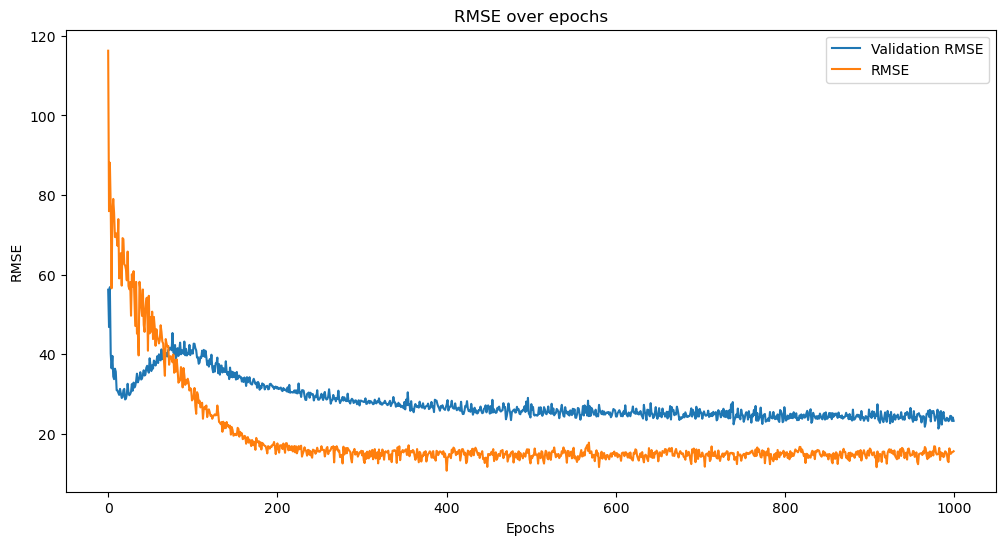

In [76]:
import matplotlib.pyplot as plt

# Assuming history.history['val_mean_absolute_error'] is your data
val_mae = history.history['val_root_mean_squared_error']
mae = history.history['root_mean_squared_error']

plt.figure(figsize=(12, 6))
plt.plot(val_mae)
plt.plot(mae)
plt.title('RMSE over epochs')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend(['Validation RMSE', 'RMSE'])
plt.show()

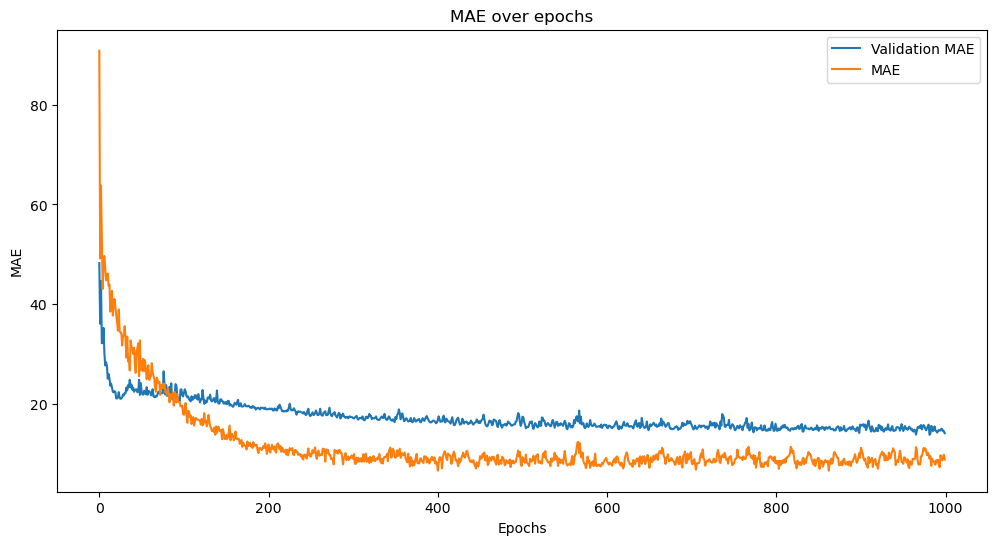

In [68]:
import matplotlib.pyplot as plt

# Assuming history.history['val_mean_absolute_error'] is your data
val_mae = history.history['val_mean_absolute_error']
mae = history.history['mean_absolute_error']

plt.figure(figsize=(12, 6))
plt.plot(val_mae)
plt.plot(mae)
plt.title('MAE over epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend(['Validation MAE', 'MAE'])
plt.show()

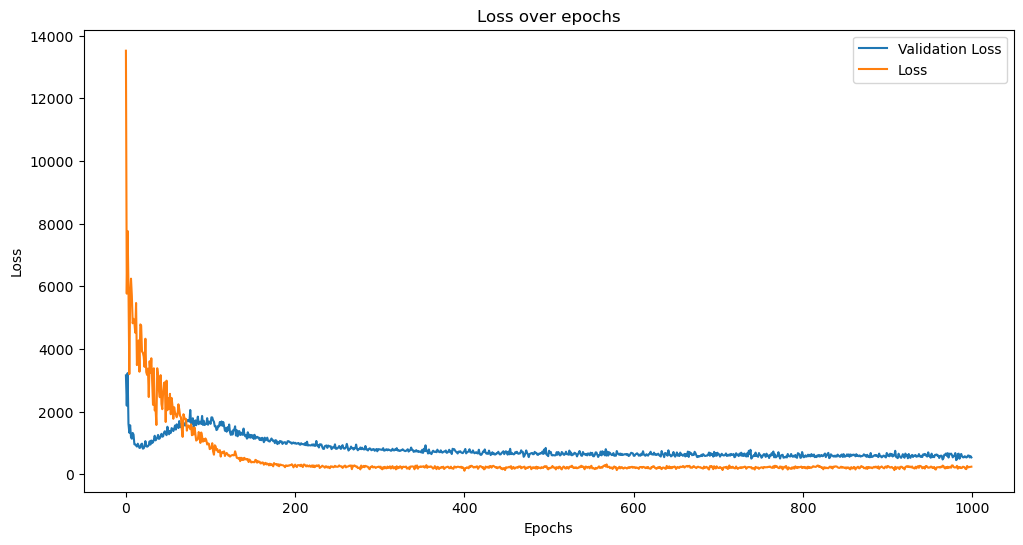

In [69]:
import matplotlib.pyplot as plt

# Assuming history.history['val_mean_absolute_error'] is your data
val_lost = history.history['val_loss']
lost = history.history['loss']

plt.figure(figsize=(12, 6))
plt.plot(val_lost)
plt.plot(lost)
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Validation Loss', 'Loss'])
plt.show()

In [74]:
test_loss, test_mae, test_rmse  = model.evaluate(test_generator, steps=len(test_data) // 32)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")
print(f"Test RMSE: {test_rmse}")

2024-06-07 06:23:08.168498: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 2s 2s/step - loss: 539.4581 - mean_absolute_error: 14.1217 - root_mean_squared_error: 23.2262
Test Loss: 539.4581298828125
Test MAE: 14.121686935424805
Test RMSE: 23.226238250732422


In [75]:
predictions = model.predict(test_generator)

df_result = pd.DataFrame({
    'File Name': test_data['File Name'],
    'Actual AQI': test_data['AQI'],
    'Predicted AQI': predictions.flatten()
})
df_result

2024-06-07 06:23:15.485191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


2/2 [==============================] - 2s 420ms/step


,File Name,Actual AQI,Predicted AQI
45,20240529_110000.jpg,104,109.697769
136,20240527_160000.jpg,53,108.127777
76,20240602_130000.jpg,107,110.264130
143,20240601_153000.jpg,147,156.003464
113,20240526_083000.jpg,56,59.085476
177,20240601_103000.jpg,155,154.966080
15,20240530_103000.jpg,122,128.518372
18,20240529_090000.jpg,104,100.829056
16,20240531_120000.jpg,153,151.190704
9,20240529_133000.jpg,149,102.304726


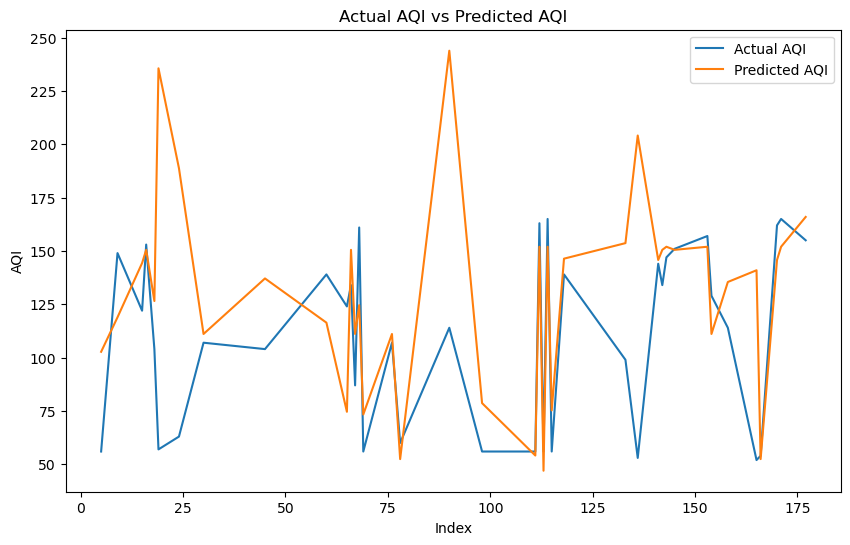

In [ ]:
import matplotlib.pyplot as plt

df_result = df_result.sort_index()
# Assuming `df_result` is your DataFrame
plt.figure(figsize=(10, 6))
plt.plot(df_result['Actual AQI'], label='Actual AQI')
plt.plot(df_result['Predicted AQI'], label='Predicted AQI')
plt.title('Actual AQI vs Predicted AQI')
plt.xlabel('Index')
plt.ylabel('AQI')
plt.legend()
plt.show()